# PHY204 – 1D solver using Numerov's method
----

## Part I – Modes of a 1D dielectric waveguide 

### Introduction

We are trying to solve the equation $$\tag{1}A''(x)+\left(\dfrac{n^2(x)\omega^2}{c^2} - \kappa^2\right)A(x) = 0,$$subject to these boundary conditions: $A(x)\to 0$ as $x\to\pm\infty$ and continuity of $A$ and its derivative everywhere (and in particular, where the index of refraction function $n$ is discontinuous). We define the new function $\gamma$ by
$$\tag{2}\gamma^2(x)=\pm\left(\dfrac{n^2(x)\omega^2}{c^2} - \kappa^2\right),$$
depending on how $\kappa$ compares with the value
$n\omega/c$. The equation becomes:
$$\tag{3}A''(x)\pm\gamma^2 A(x) = 0.$$

### Dimensionless equation

Let us perform some dimensional analysis to determine the appopriate length scale to use in the problem. Since
$$[\omega] = \mathrm{s}^{-1}\qquad{}[n]=1\qquad{}[c]=\mathrm{ms}^{-1},$$
we can introduce the length scale $$\tag{4}\boxed{\ell_0 = \dfrac{c}{\omega} = \dfrac{1}{k_0}}.$$
The differential equation can now be expressed in terms of the dimensionless position and dimensionless wavenumber, which read
$$\tag{5}\color{green}{\checkmark} \qquad{}\color{green}{\boxed{X = \dfrac{x}{\ell_0}, \qquad{}K=\dfrac{\kappa}{k_0}}\implies \boxed{\dfrac{\mathrm{d}^2A}{\mathrm{d}X^2}+\left(n^2(X)-K^2 \right) A(X) = 0}.}$$
The range of $X$ inside the **core** is therefore $X\in \left[-\dfrac{a\omega}{c},\,+\dfrac{a\omega}{c}\right]$, while the full range over which we solve the DE is $X\in \left[-\dfrac{b\omega}{c},\,+\dfrac{b\omega}{c}\right]$ (taking into account the cladding as well).

### Numerov's method 

Numerov's method allows to solve equations of the following type:

\begin{equation}
  \frac{d^2 y}{dx^2} = f(x) + g(x) y(x)
\end{equation}

Because of the absence of a first derivative and because only a linear order in $y(x)$
appears on the right side it is possible to devise a very simple order 5 method. If we discretize the $x$ axis into a set $\{x_0, x_1, \dots\}$ and use the
notation $y_n = y(x_n)$, $f_n = f(x_n)$, $g_n = g(x_n)$, Numerov's method says
you can recursively find the $y_n$'s with the following formula:

\begin{equation}
  y_{n+1} = \frac{2y_n - y_{n-1} + \frac{h^2}{12} \Big(f_{n+1} + 10 \,
  (f_n + g_n y_n) + f_{n-1} + g_{n-1}y_{n-1}\Big)}{1 - \frac{g_{n+1} h^2}{12}} + O(h^6)
\end{equation}

Notably, we can use Numerov's method to propagate backwards, which will help us find the modes of the waveguide that satisfy certain boundary conditions. 

### Implementation: 1D modes with $A(x)\to 0$ as $x\to\pm\infty$ 

*Credit: This method of solving the differential equation (with Numerov's method and both foward and backward integration) is adapted from a notebook we received from Prof. Couairon, whose aim was to solve the Schrödinger equation.*

As motivated in the previous sections, our aim is to solve the differential equation (5), while forcing that $A$ and its derivative $A'$ always be continuous and decay at infinity. Theoretically, we expect exponentially-decaying solutions in the cladding. Usually, the size of the cladding is large enough that the amplitude of the electric field at its boundary is negligible. It is therefore enough to work in a
large window $[X_\mathrm{min}, X_\mathrm{max}]$ (which defines the dimensions of the cladding) and ask for the amplitude to be zero
at $X_\mathrm{min}$ and $X_\mathrm{max}$. One can then increase the size of the window
to see if results change or not. 

The problem is how to satisfy the boundary conditions. One could in principle use the
shooting method again: start from the left with an amplitude that is zero at $x_\mathrm{min}$
and then propagate using Numerov's method all the way to $X_\mathrm{max}$ and tune the wavenumber
until the amplitude is zero at $X_\mathrm{max}$.

There is however a problem with this approach. Propagating the amplitude from the oscillatory
region into the exponentially decaying region will lead to a large error accumulation. This is
because an exponentially increasing solution is also a possible solution of the equation and
can destroy the accuracy of the algorithm. The rule of thumb is to
avoid integrating into the exponential regions.

Instead, it is more efficient to propagate both forward from the left and backward from
the right and impose that both solutions satisfy the continuity conditions at a point
$x_0$ somewhere in the oscillatory region. We follow the following steps:

1. Chose a large window (large enough that we expect the wavefunction to be
   essentially zero at the boundaries) $[X_\mathrm{min}, X_\mathrm{max}]$. Of course, $\pm a$ should fall well
   within this interval.

2. Integrate the solution first starting from $X_\mathrm{min}$ up to a given value $X = X_0$
within the interval $X_L\leqslant X_0 \leqslant X_R$. One can typically choose $X_0 = X_R$. We will
call this solution $A_L(X)$.

3. Integrate the solution starting from $X_\mathrm{max}$ down to $X = X_0$. We will call this
solution $A_R(X)$. For this, we integrate backwards using Numerov's algorithm.

4. With the correct wavenumber, the following continuity conditions should be
   satisfied at $X = X_0$, i.e.:

   \begin{align}
       A_R(X_0) &= A_L(X_0) \\
       A'_R(X_0) &= A'_L(X_0)
   \end{align}

   Both $A_R$ and $A_L$ are solutions up to a multiplicative factor. So one can always
   normalize them to be equal at $X_0$. The conditions above can then be rewritten as a
   single matching condition for the logarithmic derivative:

   \begin{equation}
       \frac{A'_R(X_0)}{A_R(X_0)} = \frac{A'_L(X_0)}{A_L(X_0)}
   \end{equation}
   
   We define a function of the wavenumber
   ```python
   def get_mismatch(wavenumber, ...)
   ```
   that returns the value of the logarithmic derivative mismatch at $X=X_0$.
      
5. Make a plot of this mismatch as a function of wavenumber. 
   
6. Find the wavenumbers for which the mismatch is zero.
   
7. Plot the amplitudes of the fields for the eigenvectors we found.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import brentq

In [2]:
no_points = 2000
c = 3e8
omega = 1e14
    
class Numerov:
    
    l_0 = c / omega
    k_0 = 1 / l_0
    eps = 0.001
    
    def __init__(self, refr_index, N, b, a, name):
        self.N = N
        self.x_min = - b * omega / c
        self.x_max = b * omega / c
        self.x = np.linspace(self.x_min, self.x_max, N)
        self.a = a
        self.b = b
        self.y = np.zeros(N)
        self.step = self.x[1]-self.x[0]
        self.name = name
        self.refr_index = np.vectorize(refr_index, otypes=[float])(self.x * c / (b * omega))
        # the refractive index has to be specified for x from -1 to 1 (normalized to the width of the fiber)
    
    def plot_index(self):
        plt.figure(figsize=(8, 3))
        plt.plot(self.x * c / omega * 1e6, self.refr_index, label='$n(x)$')
        plt.xlabel('position $x$ [µm]')
        plt.ylabel('index of refraction $n(x)$')
        plt.title('Index of refraction profile')
        plt.legend()
        plt.show()
    
    def forward_numerov(self, ind, v1, v2, n_max, K):
        self.y[ind] = v1
        self.y[ind+1] = v2
        W = (K ** 2 - self.refr_index ** 2)
        fact = self.step**2 / 12.
        for i in range(ind+2, n_max+1):
            self.y[i] = (2*self.y[i-1] - self.y[i-2] \
                         + fact*(10*W[i-1]*self.y[i-1] + W[i-2]*self.y[i-2])) / (1-W[i]*fact)
                
    def backward_numerov(self, ind, v1, v2, n_min, K):
        self.y[ind] = v1
        self.y[ind-1] = v2
        W = (K ** 2 - self.refr_index ** 2)
        fact = self.step**2 / 12.
        for i in range(ind-2, n_min-1, -1):
            self.y[i] = (2*self.y[i+1] - self.y[i+2] \
                         + fact*(10*W[i+1]*self.y[i+1] + W[i+2]*self.y[i+2])) / (1-W[i]*fact)
            
    def get_boundary(self, K):
        n_match = 0
        for i in range(0, self.N-1):
            if (self.refr_index[i]-K)*(self.refr_index[i+1]-K) < 0:
                n_match = i
        return n_match
    
    def get_mismatch(self, K):
        n_match = self.get_boundary(K)
        self.forward_numerov(0, 0.0, self.eps, n_match+1, K)
        slope_l = (self.y[n_match+1] - self.y[n_match-1]) / self.y[n_match]
        self.backward_numerov(self.N-1, 0.0, self.eps, n_match-1, K)
        slope_r = (self.y[n_match+1] - self.y[n_match-1]) / self.y[n_match]
        return slope_r - slope_l

    def plot_solution(self, K, show=True):
        # the show parameter controls if the solutions are all plotted on the same graph or not
        n_match = self.get_boundary(K)
        self.forward_numerov(0, 0.0, self.eps, n_match, K)
        self.y[0:n_match+1] /= self.y[n_match]
        self.backward_numerov(self.N-1, 0.0, self.eps, n_match, K)
        self.y[n_match:self.N] /= self.y[n_match]
        plt.xlim(self.x_min * c / omega * 1e6, self.x_max * c / omega * 1e6)
        if np.max(np.abs(self.y)) < 100:
            plt.plot(self.x * c / omega * 1e6, self.y, label=f'$k = {round(K, 3)}k_0$')
            plt.xlabel('position $x$ [µm]')
            plt.ylabel('amplitude $A(x)$')
            if show:
                plt.show()

    def plot_solution_normalized(self, K, show=True, full=False):
        # the show parameter controls if the solutions are all plotted on the same graph or not
        n_match = self.get_boundary(K)
        self.forward_numerov(0, 0.0, self.eps, n_match, K)
        self.y[0:n_match+1] /= self.y[n_match]
        self.backward_numerov(self.N-1, 0.0, self.eps, n_match, K)
        self.y[n_match:self.N] /= self.y[n_match]
        if full:
            plt.xlim(self.x_min * c / omega * 1e6, self.x_max * c / omega * 1e6)
        else:
            plt.xlim(-3 * self.a * 1e6, 3 * self.a * 1e6)
        if np.max(np.abs(self.y)) < 1e2:
            plt.plot(self.x * c / omega * 1e6, self.y / max(np.abs(self.y)), label=f'$h = {round(K, 3)}\,\kappa_0$')
            plt.xlabel('position $x$ [µm]')
            plt.ylabel('amplitude $E(x)$')
            if show:
                plt.show()
            return True
        return False
    
    def solution_normalized(self, K):
        n_match = self.get_boundary(K)
        self.forward_numerov(0, 0.0, self.eps, n_match, K)
        self.y[0:n_match+1] /= self.y[n_match]
        self.backward_numerov(self.N-1, 0.0, self.eps, n_match, K)
        self.y[n_match:self.N] /= self.y[n_match]
        return self.y / max(np.abs(self.y))

    def find_eigenmodes_brentq(self, K_min, K_max):
        # this one only returns one eigenmode at a time and the range needs to be narrowed down manually
        return brentq(self.get_mismatch, K_min, K_max)
    
    def find_eigenmodes_discretely(self, K_min, K_max):
        # this finds all the roots of the discretized solution
        wavenumber_range = np.linspace(K_min, K_max, no_points)
        mismatch = np.array([numerov.get_mismatch(K) for K in wavenumber_range])
        n_match = []
        for i in range(0, self.N-1):
            if (mismatch[i])*(mismatch[i+1]) < 0:
                n_match.append(self.find_eigenmodes_brentq(wavenumber_range[i], wavenumber_range[i+1]))
        return n_match
    
    def plot_eigenmodes(self, K_min, K_max, full=False, show=True):
        plt.figure(figsize=(8,5))
        wavenumber_range = np.linspace(K_min, K_max, no_points)
        K_modes = self.find_eigenmodes_discretely(K_min, K_max)
        K_valid = []
        for K in K_modes:
            valid = self.plot_solution_normalized(K, show=False, full=full)
            if valid:
                K_valid.append(K)
        plt.title(f'Eigenmodes in the range ${round(K_min, 1)}\kappa_0 < h < {round(K_max, 1)}\kappa_0$')
        if show:
            plt.legend()
            plt.show()
        return K_valid
    
    def theoretical_allowed_modes(self):
        # this should only be used for the classical n_1 and n_2 (constant) waveguide, or for the supergaussian
        n_min = min(self.refr_index)
        n_max = max(self.refr_index)
        radius = self.a * np.sqrt(n_max**2 - n_min**2) * omega / c
        agamma_1 = np.linspace(0, radius, 3000)
        larger_agamma_1 = np.linspace(0, 1.5*radius, 3000)
        y1 = np.tan(larger_agamma_1)
        y2 = -1/np.tan(larger_agamma_1)
        circle = np.sqrt(radius**2 - agamma_1**2)
        plt.plot(agamma_1, circle, lw=3, c='red', label=r'$\gamma_1^2+\gamma_2^2=(n_1^2-n_2^2)\frac{\omega^2}{c^2}$')
        plt.scatter(larger_agamma_1, y1, marker='.', label='even solutions')
        plt.scatter(larger_agamma_1, y2, marker='.', label='odd solutions')
        plt.xlim([0, 1.5 * radius])
        plt.ylim([0, 1.5 * radius])
        plt.xlabel('$\gamma_1 a$')
        plt.ylabel('$\gamma_2 a$')
        plt.title('Theoretically allowed modes for the optical fiber')
        plt.legend()
        plt.show()

### An optical fiber with $n_1=1.5$ (core) and $n_2=1$ (cladding)

In [3]:
core_fraction = 0.15
b = 125e-6
n_max = 1.5
n_min = 1.0
index_n = lambda x: n_max if abs(x) <= core_fraction else n_min
numerov = Numerov(index_n, no_points, b, core_fraction * b, 'step_index')

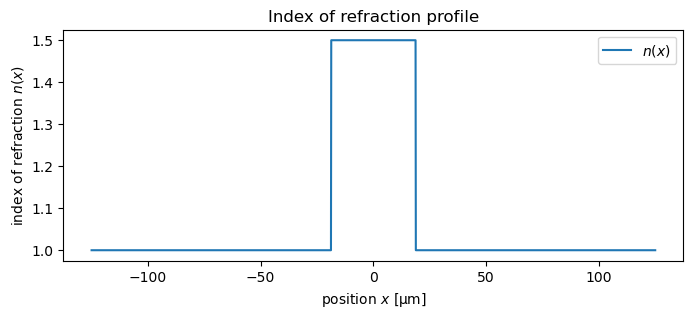

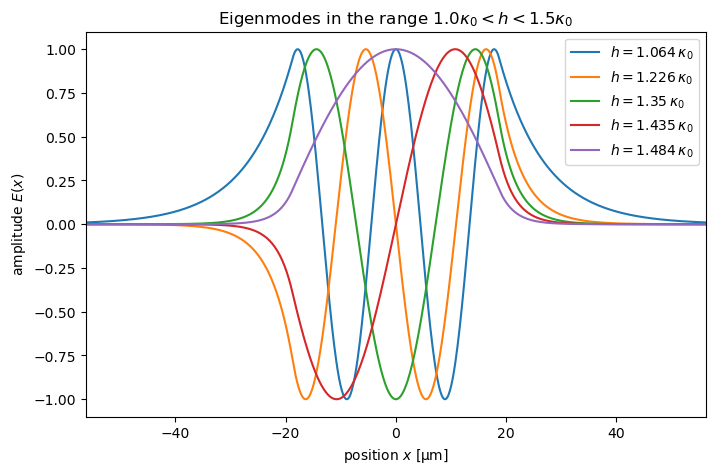

[1.0636983383645842,
 1.2264340396015754,
 1.3500560808929178,
 1.4346226090458554,
 1.4838408292556555]

In [4]:
numerov.plot_index()
numerov.plot_eigenmodes(n_min + 0.001, n_max - 0.001, full=False)

/var/folders/1p/xfd60x2n1jn6cg4yy_fclpvc0000gn/T/ipykernel_48519/205843583.py:146: RuntimeWarning: divide by zero encountered in divide
  y2 = -1/np.tan(larger_agamma_1)


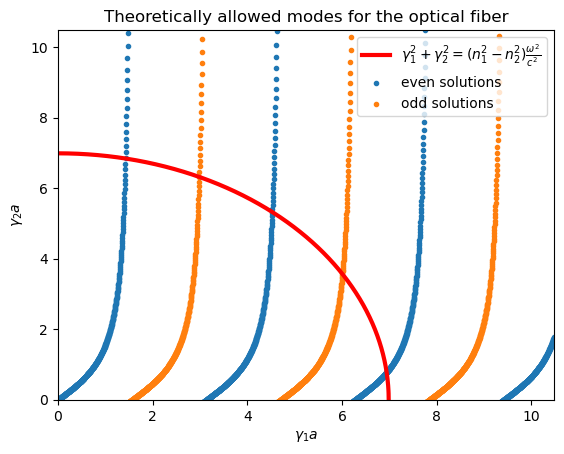

In [5]:
numerov.theoretical_allowed_modes()

### An optical fiber with $n_1=1.5$ (core) and $n_2=1$ (cladding) modelled with a supergaussian index of refraction $n(x)$

In [6]:
core_fraction = 0.15
b = 125e-6
n_max = 1.5
n_min = 1.0
index_n = lambda x: n_min + (n_max - n_min) *  np.exp(-(x / (core_fraction)) ** 26)
numerov = Numerov(index_n, no_points, b, core_fraction * b, 'supergaussian_step_index')

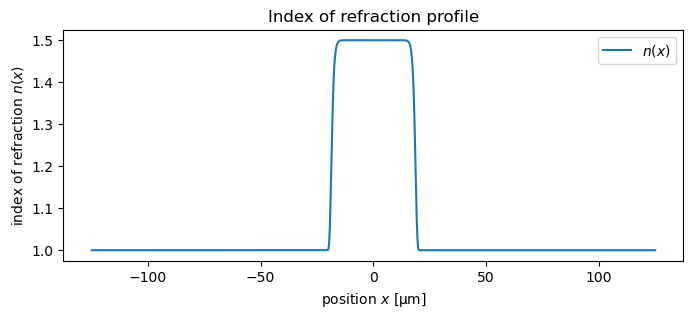

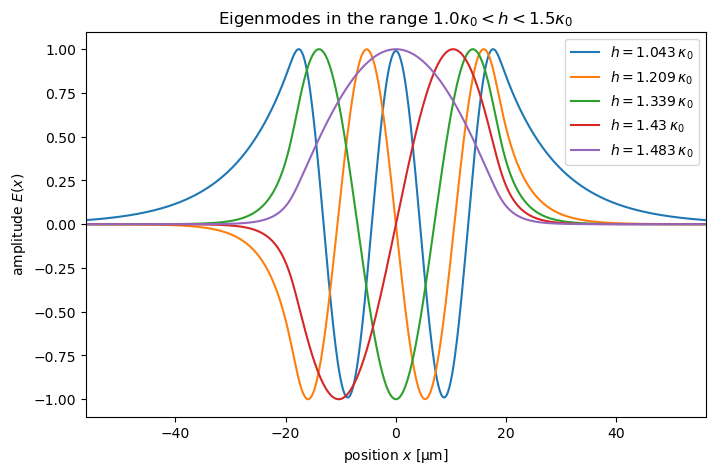

[1.0431108503257511,
 1.208779924252773,
 1.339359909692457,
 1.429702923431453,
 1.4825898659438546]

In [7]:
numerov.plot_index()
numerov.plot_eigenmodes(n_min + 0.001, n_max - 0.001, full=False)

/var/folders/1p/xfd60x2n1jn6cg4yy_fclpvc0000gn/T/ipykernel_48519/205843583.py:146: RuntimeWarning: divide by zero encountered in divide
  y2 = -1/np.tan(larger_agamma_1)


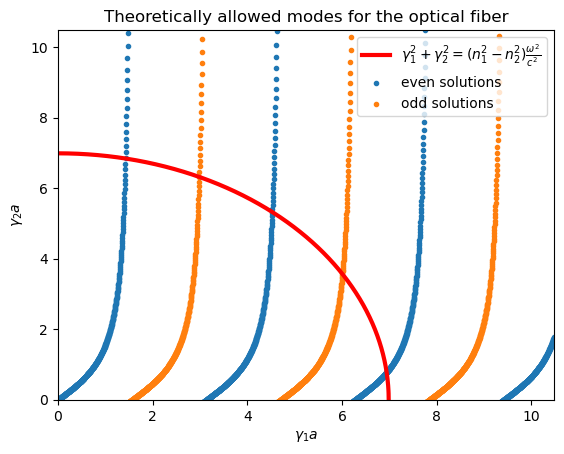

In [8]:
numerov.theoretical_allowed_modes()

### An optical fiber with two cores with $n_1=1.5$ (core) and $n_2=1$ (cladding) 

In [9]:
core_fraction = 0.09
core_centers = 0.2
b = 125e-6
n_max = 1.5
n_min = 1.0
index_n = lambda x: n_max if abs(abs(x) - core_centers) < core_fraction else n_min
numerov = Numerov(index_n, no_points, b, core_fraction * b, 'two_steps')

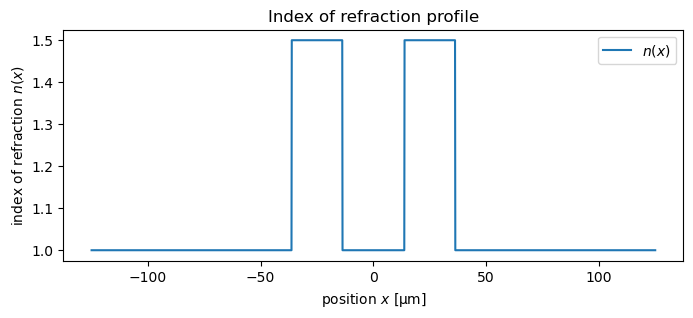

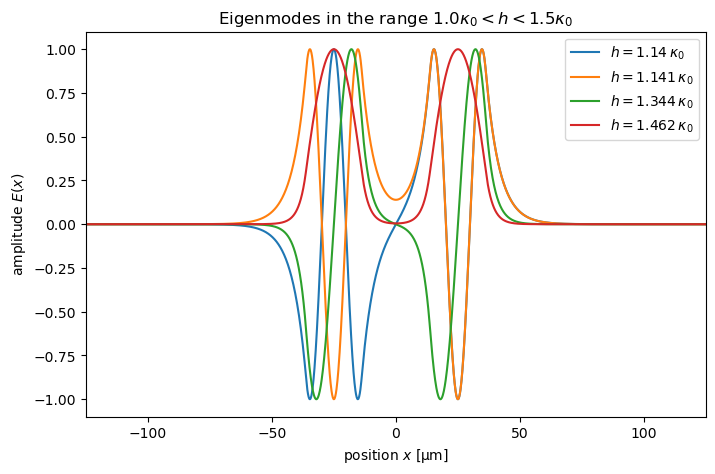

[1.1402630397443336,
 1.1411171837351957,
 1.3435548194039697,
 1.4616455431578752]

In [10]:
numerov.plot_index()
numerov.plot_eigenmodes(n_min + 0.001, n_max - 0.001, full=True)

### An optical fiber with two cores with $n_1=1.5$ (core) and $n_2=1$ (cladding) modelled with  supergaussian index of refraction profiles

In [11]:
core_fraction = 0.1
core_centers = 0.2
b = 125e-6
n_max = 1.5
n_min = 1.0
index_n = lambda x: n_min + (n_max - n_min) *  np.exp(-((x+core_centers) / (core_fraction)) ** 12) + \
                            (n_max - n_min) *  np.exp(-((x-core_centers) / (core_fraction)) ** 12)
numerov = Numerov(index_n, no_points, b, core_fraction * b, 'supergaussian_two_steps')

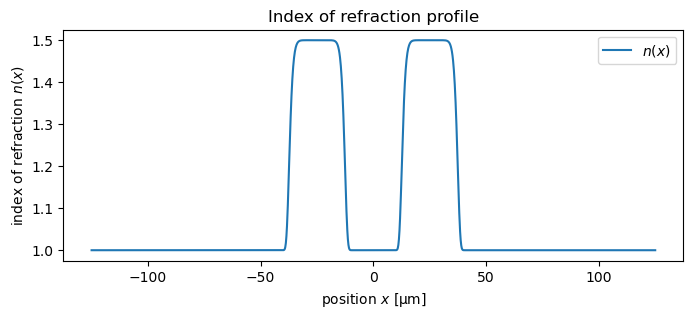

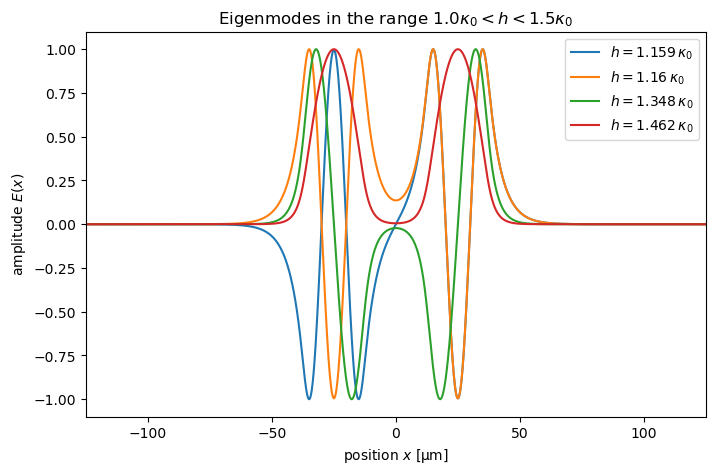

[1.1594785595172332, 1.1602951251357652, 1.3481897243415202, 1.462185623035951]

In [12]:
numerov.plot_index()
numerov.plot_eigenmodes(n_min + 0.001, n_max - 0.001, full=True)

## Part II – Power transmission in an optical fiber

### Orthogonality of guided modes

We define a functional that computes the inner product between two real, continuous functions $f_1$ and $f_2$ on the domain of the waveguide,
$$\mathcal{J}(f_1, f_2)\equiv\,\left\langle f_1,f_2\right\rangle = \int_{-b}^b f_1(x)f_2(x)\, \mathrm{d}x.$$
To see if two modes $f$ and $g$ are orthogonal, we have to check whether the condition $\mathcal{J}(f, g)=0$ is satisfied. The program computes these eigenmodes on a discrete set of equidistant points $\{x_i\}_{i=1,\dots,N}$, where $-b = x_1 < x_2 < \dots < x_{N-1} < x_N = b$. Due to this, we can approximate the inner product $\mathcal{J}(f, g)$ by the discrete sum:
$$\mathcal{J}(f, g)\approx \Delta x\sum_{i=1}^N f(x_i) g(x_i),$$
where $\Delta x=x_2-x_1=x_3-x_2=\dots=x_N-x_{N-1}$.

In [13]:
J = lambda f_1, f_2, width: width * sum(f_1 * f_2) / (f_1.size - 1)

In [14]:
# Quick test for the J function defined above with functions x^2 and x^4 on the interval -1, 1 with 1000 points
print("Testing the function J with the functions x^2 and x^4 on [-1, 1]\n")
test_mesh = np.linspace(-1, 1, 1000)
print(f"N = 1000: {J(test_mesh**2, test_mesh**4, 2)} compared to the theoretical value of 0.2857142857")

# Quick test for the J function defined above with functions x^2 and x^4 on the interval -1, 1 with 1e6 points
test_mesh = np.linspace(-1, 1, 10**6)
print(f"N = 1000000: {J(test_mesh**2, test_mesh**4, 2)} compared to the theoretical value of 0.2857142857")

Testing the function J with the functions x^2 and x^4 on [-1, 1]

N = 1000: 0.2877202957229488 compared to the theoretical value of 0.2857142857
N = 1000000: 0.285716285720264 compared to the theoretical value of 0.2857142857


Now that we have a tool to estimate the inner product between two modes, let us test it on the simplest example to check that different modes are indeed orthogonal.

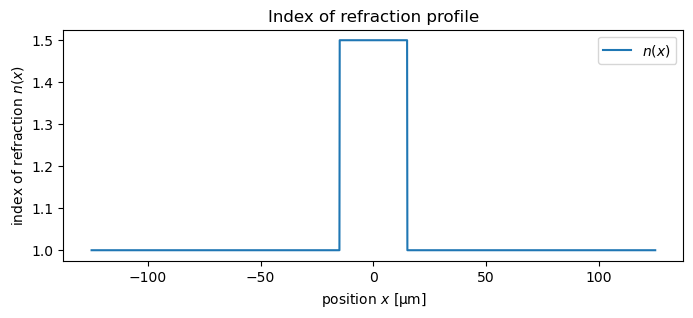

/var/folders/1p/xfd60x2n1jn6cg4yy_fclpvc0000gn/T/ipykernel_48519/205843583.py:146: RuntimeWarning: divide by zero encountered in divide
  y2 = -1/np.tan(larger_agamma_1)


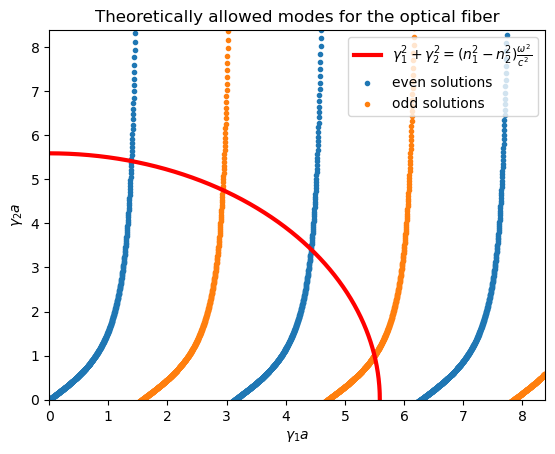

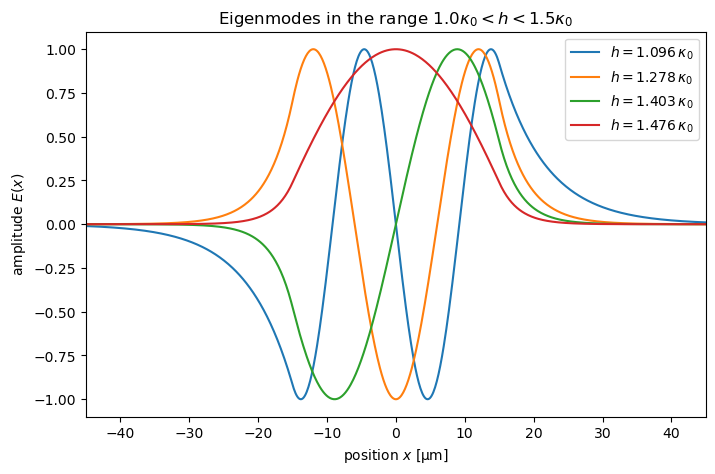

[1.4762302909270082, 1.403477616299329, 1.2775088272951507, 1.0957292814044832]
Inner product of modes 0 and 0 with 1.476 and 1.476: 8.885544240559665e-06
Inner product of modes 0 and 1 with 1.476 and 1.403: -1.8559764224720217e-19
Inner product of modes 0 and 2 with 1.476 and 1.278: 8.726880464598423e-19
Inner product of modes 0 and 3 with 1.476 and 1.096: 2.514020438590424e-20
Inner product of modes 1 and 1 with 1.403 and 1.403: 9.027578231439149e-06
Inner product of modes 1 and 2 with 1.403 and 1.278: 3.2004640208625555e-18
Inner product of modes 1 and 3 with 1.403 and 1.096: 3.392357913765864e-19
Inner product of modes 2 and 2 with 1.278 and 1.278: 9.391885729906947e-06
Inner product of modes 2 and 3 with 1.278 and 1.096: -4.078425357631608e-18
Inner product of modes 3 and 3 with 1.096 and 1.096: 1.0852682963373569e-05


In [15]:
core_fraction = 0.12
b = 125e-6
n_max = 1.5
n_min = 1.0
index_n = lambda x: n_max if abs(x) <= core_fraction else n_min
numerov = Numerov(index_n, no_points, b, core_fraction * b, 'step_index2')
numerov.plot_index()
numerov.theoretical_allowed_modes()
arr_K_vals = numerov.plot_eigenmodes(n_min + 0.001, n_max - 0.001, full=False)[::-1]
arr_K_modes = np.array([numerov.solution_normalized(v) for v in arr_K_vals])

print(arr_K_vals)

for i1, k1 in enumerate(arr_K_vals):
    for i2, k2 in enumerate(arr_K_vals[i1:]):
        print(f"Inner product of modes {i1} and {i1+i2} with {round(k1, 3)} and {round(k2, 3)}: {J(arr_K_modes[i1], arr_K_modes[i1+i2], b)}")

As we can see from this example, the numerical inner product of two different modes is about twelve orders of magnitude smaller than the inner product of any of the modes with itself. This confirms that the modes we obtained are indeed orthogonal.

### Decomposition of a gaussian laser beam into guided modes

A standard choice would be to consider a gaussian laser beam of width $w_0$ and power $P$ entering the optical fiber at normal incidence (we can assume that the laser is focused by some optical system in such a way that the beam enters the dielectric material exactly when the width of the beam is exactly the beam waist). The amplitude of the electric field of such a beam is given by
$$E(r)=E_0\exp\left(-\frac{r^2}{w_0^2}\right),\qquad{}\text{where}\qquad{} E_0 = \frac{2\sqrt{\mu_0c P}}{\sqrt{\pi} w_0}.$$

----

To treat the 1D case, we consider a similar profile in 1D, *e.g.*, a laser sheet,
$$\tag{6}E(x)\propto\exp\left(-\frac{x^2}{w_0^2}\right).$$
If the optical fiber under consideration has $m$ guided modes $f_1,\,f_2,\dots,\,f_m$ with corresponding eigenvalues $\kappa_1,\,\kappa_2,\dots,\,\kappa_m$, then we can decompose the input signal as
$$\tag{7}E(x) = \sum_{i=1}^m c_i f_i(x) + \text{continuous components due to radiative modes},$$
where the coefficients $\{c_i\}_{i=1,\dots,m}$ quantify the contribution of each mode to the profile of the input signal. More precisely, taking the inner product of $E(x)$ with itself yields
$$\tag{8}\lVert E\rVert ^2=\left\langle E, E\right\rangle=\left\langle \sum_{i=1}^m c_i f_i, \sum_{i=1}^m c_i f_i\right\rangle=\sum_{i=1}^m |c_i|^2\lVert f_i\rVert ^2.$$
Therefore, the contribution of mode $i$ can be assesed by computing the ratio $\dfrac{|c_i|^2 \lVert f_i\rVert ^2}{\lVert E\rVert ^2}$.

----

The radiative modes decay very quickly, since they lose significant power in the cladding. We therefore focus on **projecting** the incoming signal onto the guided modes of the fiber. In particular, if we project (7) onto mode $j$, by the orthogonality of the guided modes demonstrated in the previous section, we can write approximately:
$$\tag{9}\int_{-b}^b E(x)f_j(x) \,\mathrm{d}x \approx \int_{-b}^b \sum_{i=1}^m c_i f_i(x)f_j(x)\,\mathrm{d}x= \lVert f_j\rVert ^2c_j.$$
Therefore,
$$\tag{10}c_i \approx \dfrac{\int_{-b}^b E(x)f_i(x) \,\mathrm{d}x}{\int_{-b}^b f_i^2(x) \,\mathrm{d}x}=\dfrac{\left\langle E, f_i\right\rangle}{\left\langle f_i,f_i\right\rangle}.$$
The relevant ratio becomes:
$$\dfrac{|c_i|^2 \lVert f_i\rVert ^2}{\lVert E\rVert ^2}=\dfrac{\lVert f_i\rVert ^2}{\lVert E\rVert ^2} \dfrac{\left\langle E, f_i\right\rangle^2}{\left\langle f_i,f_i\right\rangle^2}=\dfrac{\left\langle E, f_i\right\rangle^2}{\lVert E\rVert ^2 \lVert f_i\rVert ^2}=\dfrac{\left\langle E, f_i\right\rangle^2}{\left\langle E, E\right\rangle \left\langle f_i, f_i\right\rangle}.$$

We now turn to the particular example of a waveguide with a step-potential that is narrow enough to allow only a single guided mode. This can be used to model, in a first approximation, a single-mode optical fiber. 

We know from the previous parts that the fundamental mode of such a waveguide looks approximately like a half-period of the cosine function, patched with exponentially-decaying tails in the cladding. Intuitively, we expect that if we choose the width $w$ of the gaussian in such a way that it matches the width of the fundamental mode, the coefficient of this mode should be quite high. 

In [16]:
def E_gaussian(w):
    return lambda x: np.exp(-x ** 2 / w ** 2)

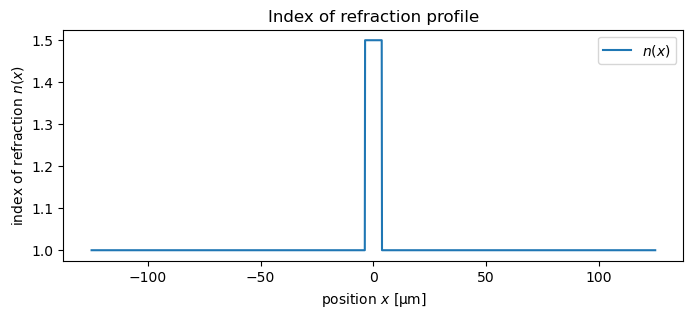

/var/folders/1p/xfd60x2n1jn6cg4yy_fclpvc0000gn/T/ipykernel_48519/205843583.py:146: RuntimeWarning: divide by zero encountered in divide
  y2 = -1/np.tan(larger_agamma_1)


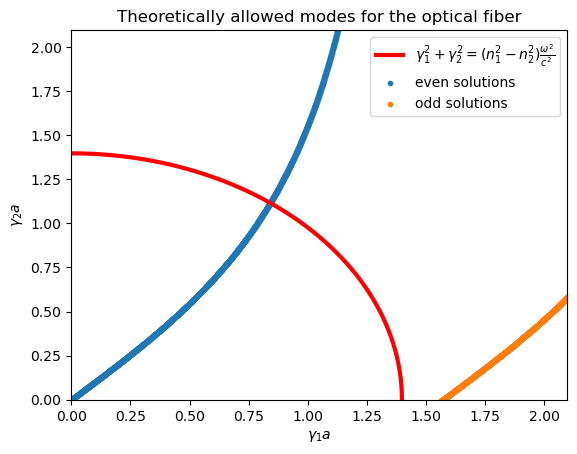

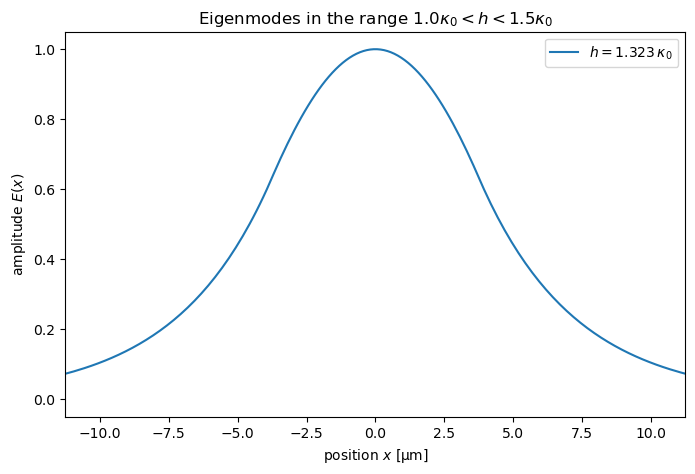

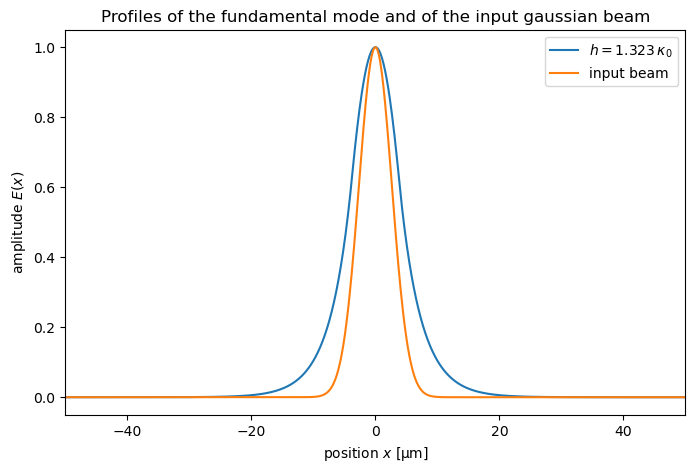

0.7690357003830656 0.9085211295115575


In [17]:
core_fraction = 0.03
b = 125e-6
n_max = 1.5
n_min = 1.0
x_arr = np.linspace(-b * 1e6, b * 1e6, no_points)
index_n = lambda x: n_max if abs(x) <= core_fraction else n_min

numerov = Numerov(index_n, no_points, b, core_fraction * b, 'single_mode')
numerov.plot_index()
numerov.theoretical_allowed_modes()
arr_K_vals = numerov.plot_eigenmodes(n_min + 0.001, n_max - 0.001, full=False)[::-1]
arr_K_modes = np.array([numerov.solution_normalized(v) for v in arr_K_vals])

def compute_contribution(fiber, modes, signal, mode_number, rel_width, plot=True, save=None):
    x_arr = np.linspace(-fiber.b * 1e6, fiber.b * 1e6, no_points)
    signal_arr = np.array([signal(1e6 * fiber.a * rel_width)(x) for x in x_arr])
    if plot:
        fiber.plot_eigenmodes(n_min + 0.001, n_max - 0.001, full=True, show=False)
        plt.plot(x_arr, signal_arr, label='input beam')
        plt.xlim(-50, 50)
        plt.title('Profiles of the fundamental mode and of the input gaussian beam')
        plt.legend()
        plt.show()
    coeff = J(signal_arr, modes[mode_number-1], fiber.b) / \
                J(modes[mode_number-1], modes[mode_number-1], fiber.b)
    contrib = J(signal_arr, modes[mode_number-1], fiber.b) ** 2 / \
                (J(signal_arr, signal_arr, fiber.b) * J(modes[mode_number-1], modes[mode_number-1], fiber.b))
    return coeff, contrib

c_1, contrib_1 = compute_contribution(numerov, arr_K_modes, E_gaussian, 1, 1, plot=True, save='gaussian_and_mode.pdf')
print(c_1, contrib_1)

We see that for this particular choice of the beam width, we obtain a contribution of about 91% of the fundamental mode. Let us sample over a wider range of input beam widths, to determine which one is closest to the fundamental of the waveguide.

The maximum contribution is reached for w = 1.593: 99.6%


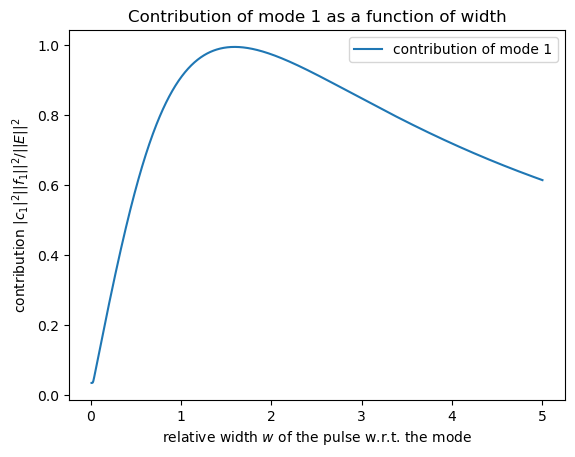

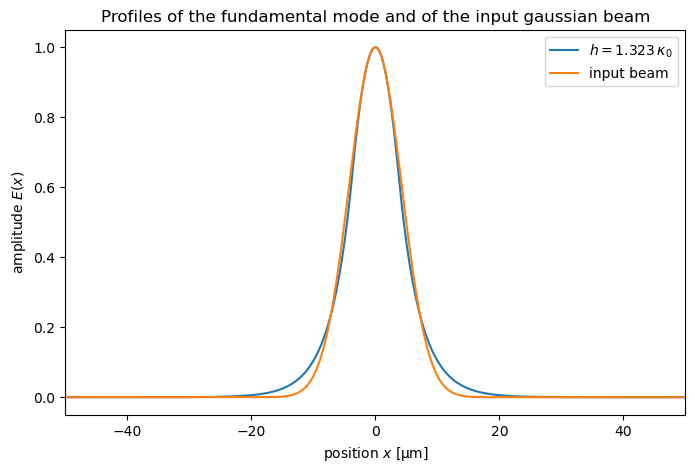

(1.0162177628457822, 0.9956051276247724)

In [18]:
def width_sample(fiber, modes, w_min, w_max, N=1000, signal=E_gaussian, mode_number=1):
    width_arr = np.linspace(w_min, w_max, N)
    coefs = []
    for w in width_arr:
        coefs.append(np.array(compute_contribution(fiber, modes, signal, mode_number, w, plot=False)))
    plt.plot(width_arr, np.array(coefs)[:,1], label=f'contribution of mode {mode_number}')
    plt.legend()
    plt.title(f"Contribution of mode {mode_number} as a function of width")
    plt.xlabel("relative width $w$ of the pulse w.r.t. the mode")
    plt.ylabel(f"contribution $|c_{mode_number}|^2 ||f_{mode_number}||^2 / ||E||^2$")
    plt.plot()
    idx, max_contrib = max(list(enumerate(coefs)), key=lambda tup: tup[1][1])
    return width_arr[idx], max_contrib[1]

w_max, contrib_max = width_sample(numerov, arr_K_modes, 0.01, 5)
print(f"The maximum contribution is reached for w = {round(w_max, 3)}: {round(contrib_max*100, 1)}%")
compute_contribution(numerov, arr_K_modes, E_gaussian, 1, w_max, plot=True, save='optimal_gaussian_and_mode.pdf')